# Feature Engineering

In [149]:
# DS18 ML Essentials project
# Module 4: Feature Engineering

# Submitted by: Tzvi Eliezer Nir
# mail: tzvienir@gmail.com
# First submission: 

## In this notebook

We will apply multiple feature enrichment methods on our data

### Chosen features:

1. datetime parsing - year, month, day + decade category, before/after internet era
2. 5 hot tokens in song title
3. artist followers

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_pickle("./pickle/03_data_cleansing/data_cleansing.pkl")

## `track_album_release_date` feature extraction

In [151]:
# Extract year, month, and day from track_album_release_date
df['year'] = df['track_album_release_date'].dt.year
df['month'] = df['track_album_release_date'].dt.month
df['day'] = df['track_album_release_date'].dt.day

# Calculate the decade
df['decade'] = (df['year'] // 10) * 10

# drop the track_album_release_date column
df = df.drop('track_album_release_date', axis=1)

# Display the updated dataframe
df.head()

,track_id,track_artist,track_popularity,track_album_id,danceability,energy,key,loudness,mode,speechiness,...,edm,latin,pop,r&b,rap,rock,year,month,day,decade
0,0017A6SJgTbfQVU2EtsPNo,Barbie's Cradle,41,1srJQ0njEQgd8w4XSqI4JQ,0.682,0.401,2,-10.068,1,0.0236,...,0,0,0,0,0,1,2001,1,1,2000
1,002xjHwzEx66OWFV2IP9dk,RIKA,15,1ficfUnZMaY1QkNp15Slzm,0.582,0.704,5,-6.242,1,0.0347,...,0,0,0,1,0,0,2018,1,26,2010
2,004s3t0ONYlzxII9PLgU6z,Steady Rollin,28,3z04Lb9Dsilqw68SHt6jLB,0.303,0.880,9,-4.739,1,0.0442,...,0,0,0,0,0,1,2017,11,21,2010
3,008MceT31RotUANsKuzy3L,The.madpix.project,24,1Z4ANBVuhTlS6DprlP0m1q,0.659,0.794,10,-5.644,0,0.0540,...,1,0,1,0,0,0,2015,8,7,2010
4,008rk8F6ZxspZT4bUlkIQG,YOSA & TAAR,38,2BuYm9UcKvI0ydXs5JKwt0,0.662,0.838,1,-6.300,1,0.0499,...,0,0,1,0,0,0,2018,11,16,2010


In [152]:
import scipy.stats as stats

decades = df['decade'].unique()
popularity_by_decade = {decade: df[df['decade'] == decade]['track_popularity'] for decade in decades}

f_statistic, p_value = stats.f_oneway(*popularity_by_decade.values())

print(f"F-statistic: {f_statistic}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference between the group means")
else:
    print("No significant difference between the group means")

F-statistic: 71.52541039234148
p-value: 4.879105730122917e-103
There is a significant difference between the group means


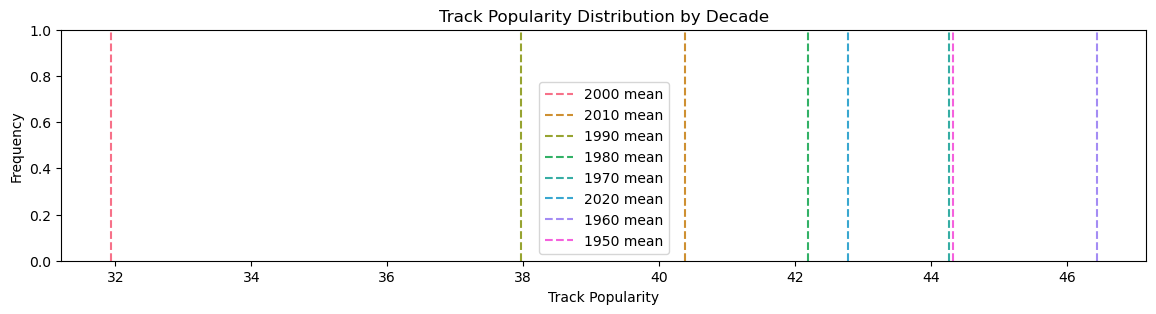

In [153]:
plt.figure(figsize=(14, 3))

# Define a color palette
palette = sns.color_palette("husl", len(decades))

# # Plot histograms for each decade
# for i, decade in enumerate(decades):
#     sns.histplot(popularity_by_decade[decade], kde=False, label=f'{decade}', bins=30, alpha=0.5, color=palette[i])

# Add vertical lines for the mean popularity of each decade
for i, decade in enumerate(decades):
    mean_popularity = popularity_by_decade[decade].mean()
    plt.axvline(mean_popularity, linestyle='--', label=f'{decade} mean', color=palette[i])

plt.title('Track Popularity Distribution by Decade')
plt.xlabel('Track Popularity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

F-statistic: 102.82085018856533
p-value: 4.033459112969597e-24
There is a significant difference between the group means


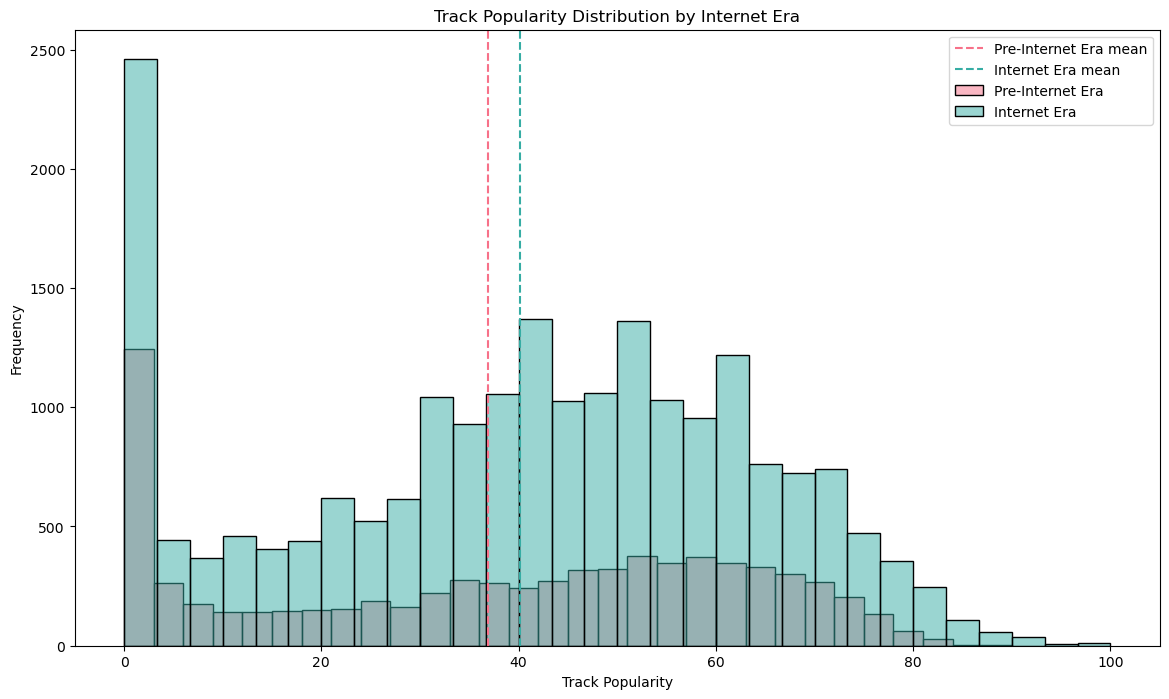

In [154]:
df['released_in_internet_era'] = (df['year'] > 2008).astype(int)

popularity_by_internet_era = {era: df[df['released_in_internet_era'] == era]['track_popularity'] for era in df['released_in_internet_era'].unique()}

f_statistic, p_value = stats.f_oneway(*popularity_by_internet_era.values())

print(f"F-statistic: {f_statistic}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference between the group means")
else:
    print("No significant difference between the group means")

plt.figure(figsize=(14, 8))

# Define a color palette
palette = sns.color_palette("husl", len(popularity_by_internet_era))

# Plot histograms for each era
for i, (era, popularity) in enumerate(popularity_by_internet_era.items()):
    sns.histplot(popularity, kde=False, label=f'{"Internet Era" if era == 1 else "Pre-Internet Era"}', bins=30, alpha=0.5, color=palette[i])

# Add vertical lines for the mean popularity of each era
for i, (era, popularity) in enumerate(popularity_by_internet_era.items()):
    mean_popularity = popularity.mean()
    plt.axvline(mean_popularity, linestyle='--', label=f'{"Internet Era" if era == 1 else "Pre-Internet Era"} mean', color=palette[i])

plt.title('Track Popularity Distribution by Internet Era')
plt.xlabel('Track Popularity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Look at that! a significant difference!

## Get hot tokens

In [155]:
df_text = pd.read_pickle("./pickle/01_data_preparation/df_text.pkl")
df_text = df_text.drop(columns=['playlist_name'])
df_text = df_text.drop_duplicates(subset='track_id')
#df_text = df_text.merge(df[['track_id', 'track_artist']], on='track_id', how='left')

df_text.describe()

,track_id,track_name,track_album_name
count,28356,28352,28352
unique,28356,23449,19743
top,6f807x0ima9a1j3VPbc7VN,Breathe,Greatest Hits
freq,1,18,135


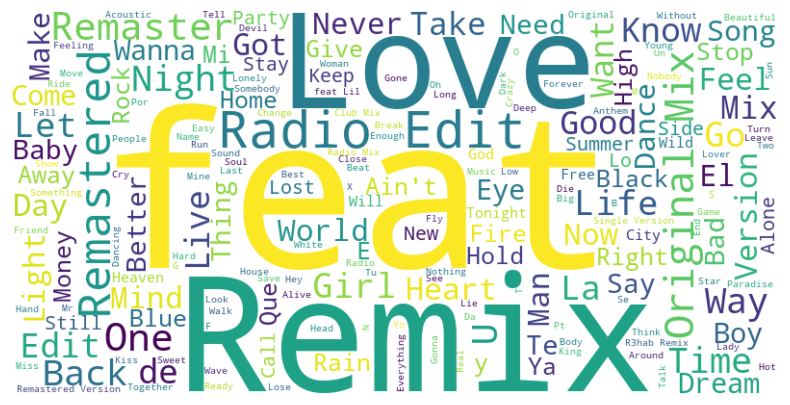

[('feat', 1.0), ('Remix', 0.8182837913628715), ('Love', 0.5339315759955132), ('Radio Edit', 0.2641615255187886), ('Remastered', 0.19125070106561975), ('Original Mix', 0.15872125630959058), ('Remaster', 0.1441390914189568), ('One', 0.14133482893998878), ('U', 0.12226584408300617), ('Back', 0.12114413909141895), ('Way', 0.12002243409983174), ('Night', 0.11721817162086372), ('Time', 0.11497476163768929), ('Go', 0.1076836791923724), ('Life', 0.10600112170499158), ('Let', 0.10487941671340438), ('Girl', 0.10431856421761077), ('Edit', 0.0975883342680875), ('Live', 0.09590577678070668), ('Know', 0.09478407178911946)]


In [156]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all track names into a single string
text = ' '.join(df_text['track_name'].dropna().values)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Get the frequencies of the words
word_frequencies = wordcloud.words_

# Print the top 20 words
top_20_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:20]
print(top_20_words)

In [157]:
df_text


,track_id,track_name,track_album_name
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,I Don't Care (with Justin Bieber) [Loud Luxury...
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Memories (Dillon Francis Remix)
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,All the Time (Don Diablo Remix)
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,Call You Mine - The Remixes
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Someone You Loved (Future Humans Remix)
...,...,...,...
32828,7bxnKAamR3snQ1VGLuVfC1,City Of Lights - Official Radio Edit,City Of Lights (Vocal Mix)
32829,5Aevni09Em4575077nkWHz,Closer - Sultan & Ned Shepard Remix,Closer Remixed
32830,7ImMqPP3Q1yfUHvsdn7wEo,Sweet Surrender - Radio Edit,Sweet Surrender (Radio Edit)
32831,2m69mhnfQ1Oq6lGtXuYhgX,Only For You - Maor Levi Remix,Only For You (Remixes)


In [158]:

# Create new features based on the top 5 words
for word, _ in top_20_words[:5]:
    df_text[word] = df_text['track_name'].apply(lambda x: 0 if pd.isna(x) else int(word.lower() in x.lower()))

df_text.sample(20)


,track_id,track_name,track_album_name,feat,Remix,Love,Radio Edit,Remastered
31889,10hzmHJ08ua88sPy5RIxiL,Dump Party - Radio Mix,Most Wanted EP,0,0,0,0,0
26903,4tbL8AtrM4hIYATf1kKp18,Where Are You Now,Where Are You Now,0,0,0,0,0
30429,04so2YoeEkrKTfmgoYRmvw,Lying We're Fine,Lying We're Fine,0,0,0,0,0
9869,0LLeuNBWPOg3XA73yab3PT,T.R.U. (Totally Rotten Underground),My Liver Will Handle What My Heart Can't,0,0,0,0,0
7103,7II7n1Qy5He7hs2Q9XIbYD,Coffee Shoppe,Lost,0,0,0,0,0
13440,4g78lI7TkiIXIOZwzflR2U,(I'm Your) Hoochie Coochie Man,Blues Greats: Muddy Waters,0,0,0,0,0
29488,63ZtaTHM7Cu3JEca5xrWi3,Favorite Sound,Favorite Sound,0,0,0,0,0
12489,32qR2DcQRSJ6G2s8SC16oP,Honky Tonk Women,Rolled Gold +,0,0,0,0,0
6303,6qvfyXGXEPEYwwqBykWw3H,Professor X,Top Boy (A Selection of Music Inspired by the ...,0,0,0,0,0
31948,2m9FaaFeLhjsWChEMDSczD,"Hit the Floor ""Power"" (feat. Dollar Man)","Hit the floor ""Power"" feat. Dollarman",1,0,0,0,0


In [159]:
# Select the relevant columns from df_text
df_text_features = df_text[['track_id', 'feat', 'Remix', 'Love', 'Radio Edit', 'Remastered']]

# Merge the features into df
df = df.merge(df_text_features, on='track_id', how='left')


In [160]:
# Display the updated dataframe
df.sample(10)

,track_id,track_artist,track_popularity,track_album_id,danceability,energy,key,loudness,mode,speechiness,...,year,month,day,decade,released_in_internet_era,feat,Remix,Love,Radio Edit,Remastered
572,0A5gdlrpAuQqZ2iFgnqBFW,Gaullin,76,4IU5ADOJ9DnVa9clXVhrEE,0.813,0.761,10,-5.687,0,0.0850,...,2018,9,7,2010,1,0,0,0,0,0
7439,22mhfCPBE5YzXWYekGJUdS,UGK,33,4jTPQq9PSlKMOm1yLx2ATN,0.733,0.531,11,-11.217,0,0.3260,...,1996,7,30,1990,0,0,0,0,0,0
10791,2y9mJxMvj0Esoy8m7HpiYd,Manuel Costa,36,0dTTFNaeyKgoXJ4bhQgd7Y,0.667,0.720,2,-7.457,1,0.0303,...,2018,6,15,2010,1,0,0,0,0,0
17748,4sT2hi5bgnG2ApK7Oq06QW,MARINA,53,1u2ACTYzVNK3vSLG0Ah4H3,0.759,0.760,9,-7.199,0,0.0322,...,2015,3,13,2010,1,0,0,0,0,0
19787,5T3xR4qk2OuhwnAOruVtjb,Showtek,0,1tBdHcGwY74NeqtxC7ptIv,0.739,0.953,11,-2.624,1,0.1330,...,2013,9,2,2010,1,0,0,0,0,0
14271,3vxNh1kdvZ1nUHYUwKNStI,Brevis,39,07ZoShhxfpc6rubBbc4xr9,0.584,0.710,1,-5.077,1,0.1400,...,2019,9,11,2010,1,0,0,0,0,0
23332,6Qm7DBWQguBzK459j4fOBt,Ed Sheeran,50,7jfNbUImln4VF01QtMpe0q,0.649,0.264,9,-9.899,1,0.2800,...,2011,6,10,2010,1,0,0,0,0,0
17500,4ocmVnBOmRFzigZrIFpEfQ,Anju,35,6EWGkx9X4oEUUGGXHAmI4v,0.512,0.328,7,-11.939,1,0.0338,...,2020,1,1,2020,1,0,0,0,0,0
7435,22koI34FpNt6irOht3N8nJ,Zoë Kravitz,48,4YU2XJH8yVtQh5oPylvoDw,0.300,0.256,9,-10.452,1,0.0398,...,2017,3,31,2010,1,0,0,0,0,0
28260,7yOv1YISwpujFFQm6blOts,Seeb,60,3zNQ4jV4bWXdIBnJZemCHI,0.530,0.444,0,-9.779,0,0.0338,...,2019,3,1,2010,1,0,0,0,0,0


## Artist followers

In [161]:
df_artist = pd.read_csv('data/04_feature_engineering/external/artists.csv')
df_artist

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0
...,...,...,...,...,...
1162090,3cOzi726Iav1toV2LRVEjp,4831.0,['black comedy'],Ali Siddiq,34
1162091,6LogY6VMM3jgAE6fPzXeMl,46.0,[],Rodney Laney,2
1162092,19boQkDEIay9GaVAWkUhTa,257.0,[],Blake Wexler,10
1162093,5nvjpU3Y7L6Hpe54QuvDjy,2357.0,['black comedy'],Donnell Rawlings,15


In [162]:
df, df_artist

# Create a dictionary for quick lookup of artist followers
artist_followers_dict = df_artist.set_index('name')['followers'].to_dict()

# Replace df['track_artist'] with corresponding followers
df['track_artist_followers'] = df['track_artist'].map(artist_followers_dict)

# Display the updated dataframe
df_sorted = df.sort_values(by='track_artist_followers', ascending=False)
df_sorted.head()



,track_id,track_artist,track_popularity,track_album_id,danceability,energy,key,loudness,mode,speechiness,...,month,day,decade,released_in_internet_era,feat,Remix,Love,Radio Edit,Remastered,track_artist_followers
21453,5ug4vqGZ3eisGhY1IsziNX,Ed Sheeran,74,6Z5DhADmyybfKNdymaPLjB,0.565,0.242,2,-8.367,1,0.0318,...,7,5,2010,1,1,0,0,0,0,78900234.0
19955,5Va44ERiHtC2tfBD53OApA,Ed Sheeran,59,0kHdDpkkSlesh2UMKhF20G,0.747,0.649,10,-6.218,0,0.2190,...,7,11,2010,1,1,0,0,0,0,78900234.0
2640,0jmTp8jaCOm78zrdzdvmaq,Ed Sheeran,0,2DL4AOHc4MKvCHbUr544aU,0.733,0.821,4,-4.982,1,0.0407,...,2,16,2010,1,0,1,0,0,0,78900234.0
25430,70eFcWOvlMObDhURTqT4Fv,Ed Sheeran,85,3oIFxDIo2fwuk4lwCmFZCx,0.640,0.648,5,-8.113,0,0.1870,...,7,12,2010,1,1,0,0,0,0,78900234.0
4150,19TOAlTFq0NDHvUPQR0tkr,Ed Sheeran,69,3BjxjIkTZKUpeZ6n5MYMNx,0.845,0.766,2,-5.727,0,0.0658,...,9,27,2010,1,1,1,0,0,0,78900234.0


In [163]:
df['track_artist_followers'] = df['track_artist_followers'].fillna(df['track_artist_followers'].median())


In [164]:
nan_count = df['track_artist_followers'].isna().sum()
print(f"Number of NaN values in 'track_artist_followers': {nan_count}")

Number of NaN values in 'track_artist_followers': 0


In [165]:
df = df.drop(columns=['track_artist'])

In [166]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
track_popularity,28356.0,3.932977e+01,2.370238e+01,0.000000,21.000000,42.000000,5.800000e+01,1.000000e+02
danceability,28356.0,6.533723e-01,1.457853e-01,0.000000,0.561000,0.670000,7.600000e-01,9.830000e-01
energy,28356.0,6.983875e-01,1.835030e-01,0.000175,0.579000,0.722000,8.430000e-01,1.000000e+00
key,28356.0,5.368000e+00,3.613904e+00,0.000000,2.000000,6.000000,9.000000e+00,1.100000e+01
loudness,28356.0,-6.817696e+00,3.036243e+00,-46.448000,-8.309250,-6.261000,-4.709000e+00,1.275000e+00
mode,28356.0,5.654888e-01,4.957014e-01,0.000000,0.000000,1.000000,1.000000e+00,1.000000e+00
speechiness,28356.0,1.079536e-01,1.025562e-01,0.000000,0.041000,0.062600,1.330000e-01,9.180000e-01
acousticness,28356.0,1.771759e-01,2.228029e-01,0.000000,0.014375,0.079700,2.600000e-01,9.940000e-01
instrumentalness,28356.0,9.111682e-02,2.325484e-01,0.000000,0.000000,0.000021,6.570000e-03,9.940000e-01
liveness,28356.0,1.909582e-01,1.558943e-01,0.000000,0.092600,0.127000,2.490000e-01,9.960000e-01


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28356 entries, 0 to 28355
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  28356 non-null  object 
 1   track_popularity          28356 non-null  int64  
 2   track_album_id            28356 non-null  object 
 3   danceability              28356 non-null  float64
 4   energy                    28356 non-null  float64
 5   key                       28356 non-null  int64  
 6   loudness                  28356 non-null  float64
 7   mode                      28356 non-null  int64  
 8   speechiness               28356 non-null  float64
 9   acousticness              28356 non-null  float64
 10  instrumentalness          28356 non-null  float64
 11  liveness                  28356 non-null  float64
 12  valence                   28356 non-null  float64
 13  tempo                     28356 non-null  float64
 14  durati

In [168]:
nan_counts = df.isna().sum()
nan_counts[nan_counts > 0]

Series([], dtype: int64)

In [169]:
df.to_csv('data/04_feature_engineering/feature_engineering.csv', index=False)

In [170]:
df.to_pickle('pickle/04_feature_engineering/feature_engineering.pkl')   # Save the dataframe to a pickle file